In [ ]:
## Titanic with keras

In [1]:
import numpy as np
import tensorflow as tf
import keras
import numpy as np
import os
import seaborn as sns
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import utils
import AAPutils
import pandas as pd
from sklearn import model_selection, metrics, preprocessing
from sklearn.compose import ColumnTransformer
# plt.rcParams['figure.figsize'] = [8.0, 6.0]

In [2]:
df = pd.read_csv('./datasets/titanic.csv')
df.describe().T

,count,mean,std,min,25%,50%,75%,max
pclass,1045.0,2.206699,0.841542,1.0000,1.00,2.00,3.0,3.0000
fare,1045.0,36.686080,55.732533,0.0000,8.05,15.75,35.5,512.3292
age,1045.0,29.851834,14.389201,0.1667,21.00,28.00,39.0,80.0000
sex,1045.0,0.628708,0.483382,0.0000,0.00,1.00,1.0,1.0000
sibsp,1045.0,0.503349,0.912471,0.0000,0.00,0.00,1.0,8.0000
parch,1045.0,0.421053,0.840052,0.0000,0.00,0.00,1.0,6.0000
survived,1045.0,0.408612,0.491813,0.0000,0.00,0.00,1.0,1.0000


In [3]:
# df.loc[:,['fare', 'age']] = df.loc[:,['fare', 'age']].astype('float')

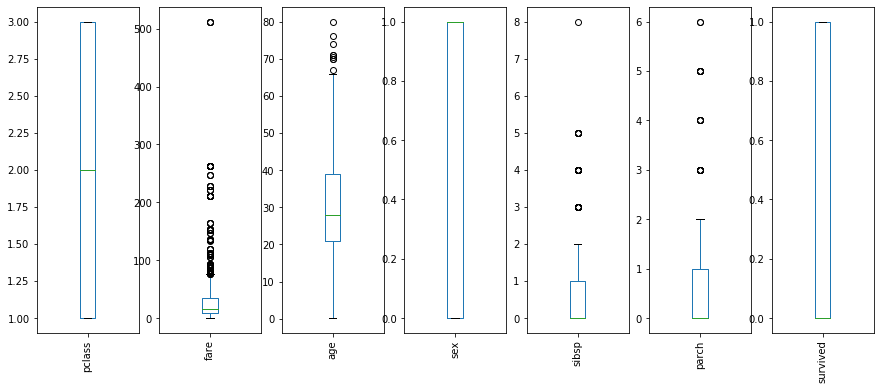

In [4]:
_ = df.plot.box(subplots=True, rot=90, figsize=(15,6))

In [5]:
# _ = df.plot.hist(subplots=True, rot=90, figsize=(10,15))

In [6]:
# podríamos transformar las categorias en one_hot: pclass y sex
# onehot_encoder = preprocessing.OneHotEncoder(sparse=False, handle_unknown='ignore')
# onehot_encoder.fit_transform(df[['pclass']])
# onehot_encoder.categories_[0]

In [146]:
X = df.loc[:,~df.columns.isin(['survived'])].values
y = df['survived'].values

In [147]:
# intento 1
# X = preprocessing.StandardScaler().fit_transform(X)

ct = ColumnTransformer([
    ("1h-pclass", 'passthrough', [0]),
    ("stand1", preprocessing.StandardScaler(), [1]),
    ("stand2", preprocessing.StandardScaler(), [2]),
    ("1h-sex", 'passthrough', [3]),
    ("stand4", preprocessing.StandardScaler(), [4]),
    ("stand5", preprocessing.StandardScaler(), [5]),
])
X = ct.fit_transform(X)


In [148]:
# intento 2
# 0 y 3 son categoricas
# ct = ColumnTransformer([
#     ("1h-pclass", preprocessing.OneHotEncoder(categories='auto'), [0]),
#     ("stand1", preprocessing.StandardScaler(), [1]),
#     ("stand2", preprocessing.StandardScaler(), [2]),
#     ("1h-sex", preprocessing.OneHotEncoder(categories='auto'), [3]),
#     ("stand4", preprocessing.StandardScaler(), [4]),
#     ("stand5", preprocessing.StandardScaler(), [5]),
    
# ])
# X = ct.fit_transform(X)
# 1 2 4 5 son númericas


In [149]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y, test_size=0.3, random_state=7)

In [150]:
d_in = X.shape[1]
d_out = np.unique(y).size
classes = d_out

In [151]:
# verificamos los valores
d_in, d_out, X_train.shape, y_train.shape, X_test.shape, y_test.shape,

(6, 2, (731, 6), (731,), (314, 6), (314,))

In [152]:
# y_test.reshape(-1,1)
utils.calculate_class_weight(y_train)

{0: 0.5937072503419972, 1: 0.4062927496580027}

In [153]:
weight = {
    0: 0.55, 1: 0.45
}

In [154]:
layers = []

layer1 = keras.layers.Dense(
    20, 
    input_shape=(d_in,), 
    activation='relu'
)
layers.append(layer1)


layer2 = keras.layers.Dense(
    10, 
    activation='relu'
)
layers.append(layer2)


layers.append(
    keras.layers.Dense(
    10, 
    activation='relu'
))

layers.append(keras.layers.Dense(
    10, 
    activation='relu'
))

layers.append(keras.layers.Dense(
    10, 
    activation='relu'
))


# https://en.wikipedia.org/wiki/Logit
# la ultima capa si o si tiene que tener tantas salidas como clases, y softmax 
output = keras.layers.Dense(classes, activation='softmax')
layers.append(output)

# Creo un modelo logístico
model = keras.Sequential()

for l in layers:
    model.add(l)

# posibles optimizadores:
# https://keras.io/optimizers/

alpha = 0.01
epochs = 1500

model.compile(
  optimizer= keras.optimizers.SGD(lr=alpha), 
  loss='sparse_categorical_crossentropy', # error para ir calculando en cada iteracion o batch 
  # Agregamos el accuracy del modelo
  metrics=[
      'accuracy', 
      #'sparse_categorical_accuracy'
  ], 
)

In [155]:
# Entrenamiento del modelo
history = model.fit(
    X_train, 
    y_train, 
    epochs=epochs, 
    batch_size=32, 
    verbose=0, 
#     initial_epoch=400,
    callbacks = [
        # https://stackoverflow.com/questions/43906048/keras-early-stopping
        # https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
        # Early stopping callback is called on every epoch end, compares the best monitored value with the current one and stops if conditions are met
       keras.callbacks.callbacks.EarlyStopping(
           monitor='val_loss', 
#            min_delta=0, 
           patience=50,
           verbose=0, 
           mode='auto', 
#            baseline=0.3, 
           restore_best_weights=True
       )
    ],
    validation_data = (X_test, y_test),
    class_weight = weight # acá va esto? o el de train?
)

In [156]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_76 (Dense)             (None, 20)                140       
_________________________________________________________________
dense_77 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_78 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_79 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_80 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_81 (Dense)             (None, 2)                 22        
Total params: 702
Trainable params: 702
Non-trainable params: 0
_______________________________________________________

In [157]:
print(metrics.classification_report(y_test, model.predict_classes(X_test)))

              precision    recall  f1-score   support

           0       0.79      0.91      0.84       184
           1       0.84      0.65      0.73       130

    accuracy                           0.80       314
   macro avg       0.81      0.78      0.79       314
weighted avg       0.81      0.80      0.80       314



In [158]:
print(metrics.classification_report(y_train, model.predict_classes(X_train)))

              precision    recall  f1-score   support

           0       0.82      0.91      0.86       434
           1       0.84      0.70      0.76       297

    accuracy                           0.82       731
   macro avg       0.83      0.80      0.81       731
weighted avg       0.83      0.82      0.82       731



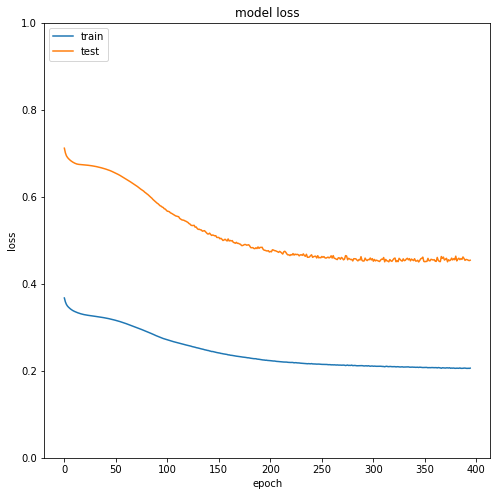

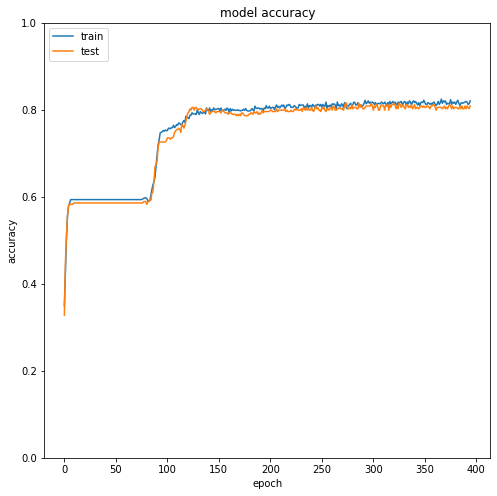

In [159]:
for k, i in zip(list(range(len(model.metrics_names))), model.metrics_names):
    plt.figure(figsize=(8,8))
    plt.ylim(0,1)
    utils.plot_curve(history, i)

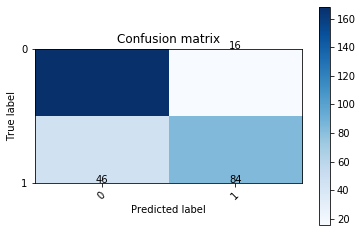

In [160]:
AAPutils.plot_confusion_matrix(y_test, model.predict_classes(X_test))

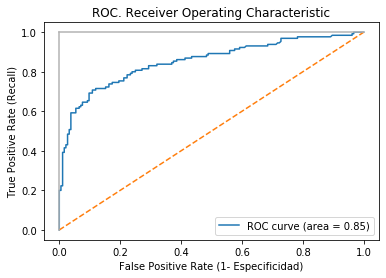

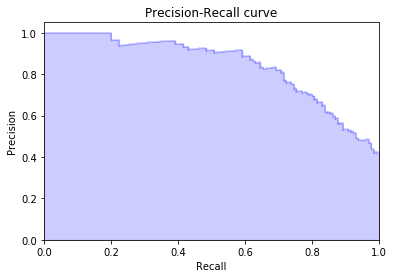

In [161]:
AAPutils.plot_ROC_curve(model, X_test, y_test)

### Conclusiones
sin escalar los valores
- 1 sola capa, epochs = 700 
    - el modelo frena en 200 épocas.
    - el f1score en test es 0.8 aprox
    - el f1-score en train es 0.85
    - probamos con más neuronas pero no aprende más: óptimo (por ahora) 150-180
- 2 capas, epochs = 700
    - Tarda un poco más en entrenar
    - en 100 epocas empieza a overfitear. Si pongo el earlystopping para en 200 de nuevo
    - entre 50 y 150 neuronaes tengo el mismo resultado
    - resultados similares a la solución de arriba
- 3 capas, epochs = 700
    - en 100 epocas empieza a overfittear. a los 20

- escalando los datos
- escalamos todas las columnas (hasta pclass)
- 1 sola capa, epochs = 700
    - overfitting temprano (50 epochs, 150 neuronas)
    - No hay mejoras entre 50 y 150 neuronas
    - f1 menor .8 en testing
    - f1 mayor a .85 en train
- 2 capas
    - con 300->150 se sobreentrena mucho
    - sgd es un poco más suave que adam
    - step0.005 y epocs 700, hizo early en 400 epocas aprox. f1: 81 para ambos
    - 20->10 tiene la misma perfrmance que cualquier combinación grande
    - ahí, aprox en 100 ya comienza a overfittear
    
- Con one-hot y standardScaler, 2 capas, no hubo mejora, siempre en 0.82
- agregué 5 capas y el modelo no tuvo mejoría. 0.8x tantos es el resultado final
- con paramétros más grandes: alpha 0.01 y epochs 1500 siempre llega a 0.8 capa 1 de 512 neuronas
- cambié los weights y tampoco.

- entender como leer ROC y precision-recall curve


In [311]:
from xgboost import XGBClassifier

clf = XGBClassifier()
clf_hist = clf.fit(
    X_train, 
    y_train,
    eval_metric='logloss', 
    verbose=1,
    eval_set=[(X_train, y_train), (X_test, y_test)]
)


[0]	validation_0-logloss:0.649998	validation_1-logloss:0.649178
[1]	validation_0-logloss:0.614494	validation_1-logloss:0.613245
[2]	validation_0-logloss:0.584909	validation_1-logloss:0.583401
[3]	validation_0-logloss:0.560241	validation_1-logloss:0.558876
[4]	validation_0-logloss:0.539142	validation_1-logloss:0.537892
[5]	validation_0-logloss:0.521411	validation_1-logloss:0.519883
[6]	validation_0-logloss:0.506124	validation_1-logloss:0.505539
[7]	validation_0-logloss:0.493053	validation_1-logloss:0.492857
[8]	validation_0-logloss:0.481923	validation_1-logloss:0.482386
[9]	validation_0-logloss:0.472301	validation_1-logloss:0.474279
[10]	validation_0-logloss:0.463799	validation_1-logloss:0.466336
[11]	validation_0-logloss:0.456482	validation_1-logloss:0.460459
[12]	validation_0-logloss:0.450152	validation_1-logloss:0.456139
[13]	validation_0-logloss:0.444336	validation_1-logloss:0.451558
[14]	validation_0-logloss:0.438965	validation_1-logloss:0.44785
[15]	validation_0-logloss:0.434248	v

In [312]:
print(metrics.classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.80      0.91      0.85       184
           1       0.84      0.68      0.75       130

    accuracy                           0.82       314
   macro avg       0.82      0.80      0.80       314
weighted avg       0.82      0.82      0.81       314



In [313]:
print(metrics.classification_report(y_train, clf.predict(X_train)))

              precision    recall  f1-score   support

           0       0.85      0.94      0.89       434
           1       0.90      0.76      0.83       297

    accuracy                           0.87       731
   macro avg       0.88      0.85      0.86       731
weighted avg       0.87      0.87      0.87       731



In [145]:
clf_hist.evals_result()

NameError: name 'clf_hist' is not defined